In [30]:
%pylab inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,auc
from datetime import datetime

Populating the interactive namespace from numpy and matplotlib


In [7]:
path='C:/Users/user/Desktop/JupyterNotebook/exam/'
df=pd.read_csv(path+'train_offline.csv')
test=pd.read_csv(path+'test_offline.csv')

查看缺失值

In [8]:
df.isnull().sum()

User_id               0
Merchant_id           0
Coupon_id        413773
Discount_rate    413773
Distance          69826
Date_received    413773
Date             704033
dtype: int64

In [14]:
#去除沒優惠券的資料
test=test[~test['Coupon_id'].isna()]
df=df[~df['Coupon_id'].isna()]
sub=test.copy()

製造目標函數

In [12]:
df['Date']=pd.to_datetime(df['Date'],format='%Y%m%d')
df['Date_received']=pd.to_datetime(df['Date_received'],format='%Y%m%d')
df['Date_delta']=df['Date']-df['Date_received']
df['label']=df['Date_delta'].apply(lambda x:1 if x<=pd.Timedelta(15,'D') else 0)

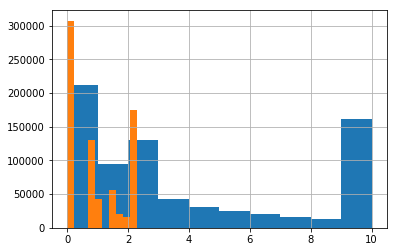

In [15]:
#距離欄位處理
df['Distance'].hist() #先觀察資料分布
df['Distance']=df['Distance'].fillna(df['Distance'].median())
sub['Distance']=sub['Distance'].fillna(sub['Distance'].median())
df['log_Distance']=df['Distance'].apply(lambda x:x if x<1 else np.log(x))
sub['log_Distance']=sub['Distance'].apply(lambda x:x if x<1 else np.log(x))
df['log_Distance'].hist()

票券資料處理

In [32]:
df['Date_received']=df['Date_received'].apply(lambda x:datetime.strptime(x,'%Y%m%d'))
#獲得票券取得星期
df['cupon_week']=df['Date_received'].apply(lambda x:x.weekday())
sub['cupon_week']=sub['Date_received'].apply(lambda x:x.weekday())
#票券種類
df['CouponType']=df['Discount_rate'].apply(lambda x:1 if ':' in x else 0)
sub['CouponType']=sub['Discount_rate'].apply(lambda x:1 if ':' in x else 0)
#票券折扣率
def rate(row):
    if ":" in row:
        rows=row.split(':')
        return float(rows[1])/float(rows[0])
    else:
        return float(row)
df['CoupinRate']=df['Discount_rate'].astype('str').apply(rate)
sub['CoupinRate']=sub['Discount_rate'].astype('str').apply(rate)
#滿額多少才能折扣
def get(row):
    if ':' in row:
        rows=row.split(':')
        return int(rows[0])
    else:
        return 0
df['getDiscount']=df['Discount_rate'].astype('str').apply(get)
sub['getDiscount']=sub['Discount_rate'].astype('str').apply(get)


TypeError: strptime() argument 1 must be str, not Timestamp

In [33]:
#Merchant_id 轉文字
df['Merchant_id']=df['Merchant_id'].astype('str')
sub['Merchant_id']=sub['Merchant_id'].astype('str')
#新增日期
df['Date_received']=df['Date_received'].astype(str).apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
df['Day']=df['Date_received'].apply(lambda x:datetime.strftime(x,'%d')).astype('int64')
sub['Date_received']=sub['Date_received'].astype(str).apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))
sub['Day']=sub['Date_received'].apply(lambda x:datetime.strftime(x,'%d')).astype('int64')


ValueError: time data '20160528.0' does not match format '%Y-%m-%d'

In [20]:
#要訓練的特徵
df.columns
feature=['Merchant_id','log_Distance','cupon_week','CouponType','CoupinRate','getDiscount','Day']
#分割資料
def train_valid_split(row,data_cut='20160416'):
    is_train=True if pd.to_datetime(row,format='%Y%m%d')<pd.to_datetime(data_cut,format='%Y%m%d') else False
    return is_train
df['is_train']=df['Date_received'].apply(train_valid_split)
train=df[df['is_train']]
valid=df[~df['is_train']]
train.reset_index(drop=True,inplace=True)
valid.reset_index(drop=True,inplace=True)
print("Train size: {}, #positive: {}".format(len(train), train["label"].sum()))
print("Valid size: {}, #positive: {}".format(len(valid), valid["label"].sum()))

Train size: 667753, #positive: 32472
Valid size: 79216, #positive: 3832


In [28]:
#梯度提升機
gdbt=GradientBoostingClassifier(n_estimators=100)
gdbt.fit(train[feature],train['label'])
gdbt_pred=(valid[feature])
print('AUC_Score:',roc_auc_score(valid['label'],gdbt_pred))

KeyError: "['CouponType' 'CoupinRate' 'getDiscount' 'Day'] not in index"